# SQL Query Composition

This notebook builds on previous notebooks that illustrate relatively simple SQL queries (queries with a single `SELECT` statement to retrieve and analyze BigQuery data). This notebooks illustrates how Google BigQuery allows you to use nested queries to create complex queries that successively filter or slice/dice results or perform joins in a single query issued to the service. Constructing these complex queries can often be made easier when done step-by-step.

This notebook introduces a pattern for developing queries independently, and then stitching them together to construct a complete solution.

## Scenario

As in other sample notebooks, this notebook will build on the HTTP logs dataset. The goal is to build a latency distribution curve of requests. This helps visualize the latency pattern of a web server.

**Preface on Notebook Content**

Although query composition through step-by-step building is intrinsically iterative, this notebook solution represents a snapshot of the final state. For illustrative purposes, each step of the iteration is broken out into separate sections, but it's unlikely you'll do the same in a real-task scenario.

In [1]:
import google.datalab.bigquery as bq

# Step 1 - Inspecting Latencies

The first step is to get an initial slice of the data we're working with with a very basic query.

In [4]:
%%bq query
SELECT latency FROM `cloud-datalab-samples.httplogs.logs_20140615` WHERE endpoint = 'Recent' LIMIT 10

latency
317
197
427
187
75
226
293
331
329
231


In [5]:
%%bq query
SELECT MIN(latency) AS min, MAX(latency) AS max, COUNT(latency) AS count
FROM `cloud-datalab-samples.httplogs.logs_20140615`
WHERE endpoint = 'Recent'

min,max,count
2,18715,734


# Step 2 - Bucketing Latencies

Clearly, latencies are discrete numbers (milliseconds) over a wide range. One way to deal with this is to bucket them into groups.

In [6]:
%%bq query -n latencyGroups
SELECT SAFE_CAST(latency/25 AS INT64) * 25 AS latency, COUNT(latency) AS requests
FROM `cloud-datalab-samples.httplogs.logs_20140615`
WHERE endpoint = 'Recent'
GROUP BY latency
ORDER BY latency

In [7]:
%bq execute --query latencyGroups

latency,requests
0,28
25,41
50,6
75,35
100,32
125,17
150,5
175,28
200,100
225,109


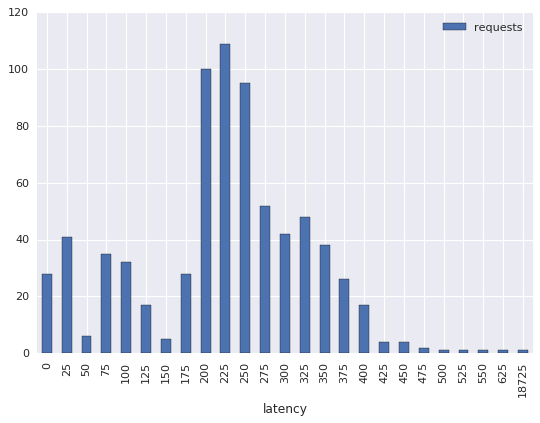

In [8]:
results = latencyGroups.execute(output_options=bq.QueryOutput.dataframe()).result()
results.set_index('latency').plot(kind='bar')

# Step 3 - Latency Distribution

In this step, we want to determine the percentage of requests that fall within each bucket. In order to compute percentages, we need to issue a count query to determine counts:

In [9]:
%%bq query -n buckets
SELECT SAFE_CAST(latency / 25 AS INT64) * 25 AS latency, COUNT(latency) AS requests
FROM `cloud-datalab-samples.httplogs.logs_20140615`
WHERE endpoint = 'Recent'
GROUP BY latency
ORDER BY latency

In [10]:
%%bq query -n stats
SELECT COUNT(latency) AS total
FROM `cloud-datalab-samples.httplogs.logs_20140615`
WHERE endpoint = 'Recent'

We can then use the buckets along with counts to produce percentage values. To do this, we can reference the queries defined above in a new queries, using the `--subqueries` argument:

In [11]:
%%bq query -n latencyDistribution --subqueries buckets stats
SELECT buckets.latency AS latency,
       buckets.requests AS requests,
       buckets.requests * 100 / stats.total AS percent
FROM buckets CROSS JOIN stats
ORDER BY latency

We can inspect the fully composed SQL represented by the query by printing its `sql` property.

In [12]:
print latencyDistribution.sql

WITH buckets AS (SELECT SAFE_CAST(latency / 25 AS INT64) * 25 AS latency, COUNT(latency) AS requests
FROM `cloud-datalab-samples.httplogs.logs_20140615`
WHERE endpoint = 'Recent'
GROUP BY latency
ORDER BY latency),
stats AS (SELECT COUNT(latency) AS total
FROM `cloud-datalab-samples.httplogs.logs_20140615`
WHERE endpoint = 'Recent')
SELECT buckets.latency AS latency,
       buckets.requests AS requests,
       buckets.requests * 100 / stats.total AS percent
FROM buckets CROSS JOIN stats
ORDER BY latency


Or by just calling the query object itself. Datalab makes inspecting objects (such as Queries) easy by defining a friendly HTML render format for them:

In [13]:
latencyDistribution

BigQuery Query - SELECT buckets.latency AS latency,
       buckets.requests AS requests,
       buckets.requests * 100 / stats.total AS percent
FROM buckets CROSS JOIN stats
ORDER BY latency

Notice that the `buckets` and `stats` queries have been inlined as nested queries and used in a `JOIN`. The resulting SQL represents a single query that can be executed in BigQuery.

In [14]:
%bq execute -q latencyDistribution

latency,requests,percent
0,28,3.81471389646
25,41,5.58583106267
50,6,0.817438692098
75,35,4.76839237057
100,32,4.35967302452
125,17,2.31607629428
150,5,0.681198910082
175,28,3.81471389646
200,100,13.6239782016
225,109,14.8501362398


We can also execute it as a dataframe to and plot its results:

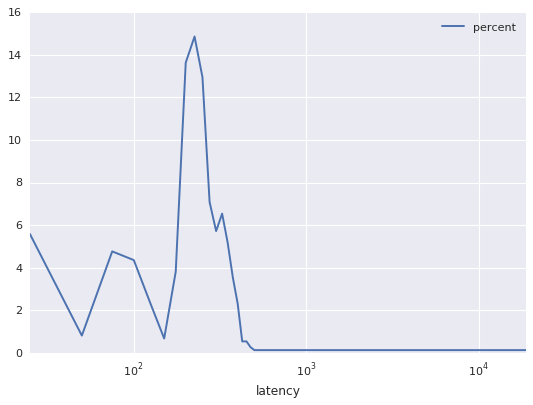

In [15]:
job = latencyDistribution.execute(output_options=bq.QueryOutput.dataframe())
job.result().drop(['requests'], axis = 1).set_index('latency').plot(logx = True)

# Looking Ahead

Composing queries one step at a time and validating the results along the way (by either executing or sampling intermediate queries) allows you to build sophisticated queries while containing the complexity.

Look at some of the BigQuery samples for more examples.